In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
ls

drive/  sample_data/


In [ ]:
import os
import cv2
from PIL import Image
import numpy as np
import scipy
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import auc, roc_curve
from tqdm import tqdm

import time

In [ ]:
import keras
import tensorflow as tf
from keras import layers
from keras.models import Model
from keras.layers import Lambda, concatenate
from tensorflow.keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import GlobalAveragePooling2D , Conv2D , MaxPooling2D
from keras.layers import  Dropout , BatchNormalization , Dense
from keras.optimizers import Adam
from tensorflow.keras.applications.resnet50 import ResNet50
from keras.callbacks import Callback , ReduceLROnPlateau , ModelCheckpoint
from sklearn.metrics import cohen_kappa_score, accuracy_score
from keras.losses import categorical_crossentropy as logloss
from keras.metrics import categorical_accuracy

**Load the Dataset as Numpy array file**

In [ ]:
benign_train = np.load('/content/drive/MyDrive/CSE499/numpy/benign_train.npy')
malign_train = np.load('/content/drive/MyDrive/CSE499/numpy/malign_train.npy')
benign_test = np.load('/content/drive/MyDrive/CSE499/numpy/benign_test.npy')
malign_test = np.load('/content/drive/MyDrive/CSE499/numpy/malign_test.npy')
print('Done Loaded :)')

In [ ]:
#Shape of our dataset
print(f'Benign Train:',benign_train.shape)
print(f'Malignant Train',malign_train.shape)
print(f'Benign Test:',benign_test.shape)
print(f'Malignant Test',malign_test.shape)

Benign Train: (3500, 224, 224, 3)
Malignant Train (3496, 224, 224, 3)
Benign Test: (1500, 224, 224, 3)
Malignant Test (1500, 224, 224, 3)


**Visualization**


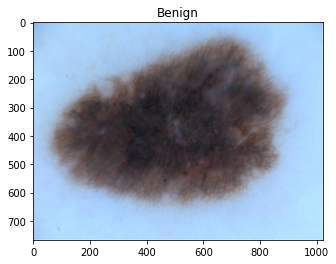

In [ ]:
im = cv2.imread('/content/drive/MyDrive/CSE499/Dataset/train/benign/ISIC_0000000.jpeg')
im_resized = cv2.resize(im, (224, 224), interpolation=cv2.INTER_LINEAR)

plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
plt.title('Benign')
plt.show()

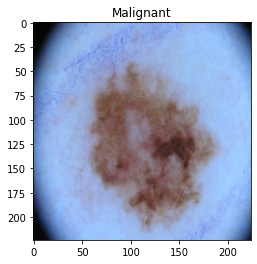

In [ ]:
im = cv2.imread('/content/drive/MyDrive/CSE499/Dataset/train/malignant/ISIC_0000002.jpeg')
im_resized = cv2.resize(im, (224, 224), interpolation=cv2.INTER_LINEAR)

plt.imshow(cv2.cvtColor(im_resized, cv2.COLOR_BGR2RGB))
plt.title('Malignant')
plt.show()

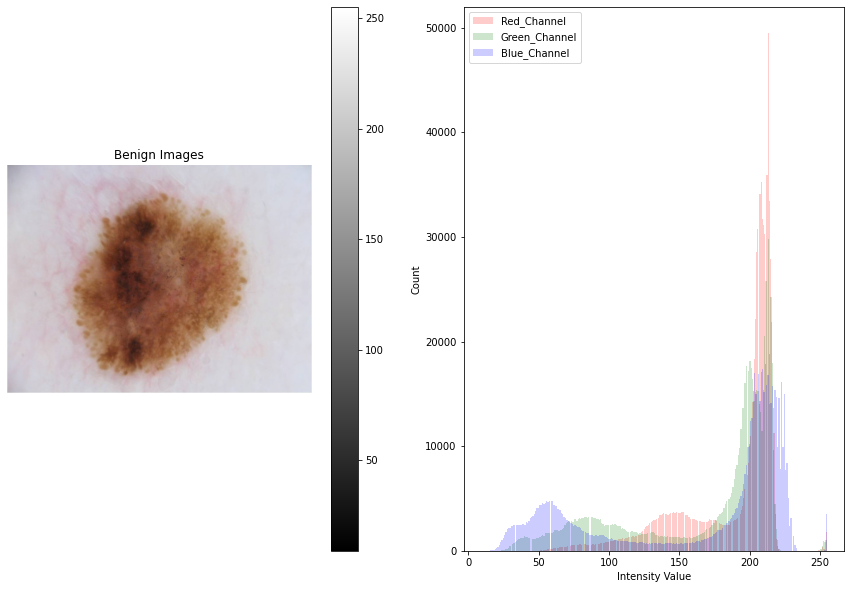

In [ ]:
img = cv2.imread('/content/drive/MyDrive/CSE499/Dataset/train/benign/ISIC_0000008.jpeg')
f = plt.figure(figsize=(15,10))
f.add_subplot(1,2,1)

images = plt.imread('/content/drive/MyDrive/CSE499/Dataset/train/benign/ISIC_0000008.jpeg')
plt.imshow(images, cmap='gray')
plt.axis('off')
plt.colorbar()
plt.title('Benign Images')

f.add_subplot(1,2,2)
_= plt.hist(images[:, :, 0].ravel(), bins = 256, color = 'red', alpha = 0.2)
_ = plt.hist(images[:, :, 1].ravel(), bins = 256, color = 'Green', alpha = 0.2)
_ = plt.hist(images[:, :, 2].ravel(), bins = 256, color = 'Blue', alpha = 0.2)
_ = plt.xlabel('Intensity Value')
_ = plt.ylabel('Count')
_ = plt.legend(['Red_Channel', 'Green_Channel', 'Blue_Channel'])
plt.show()

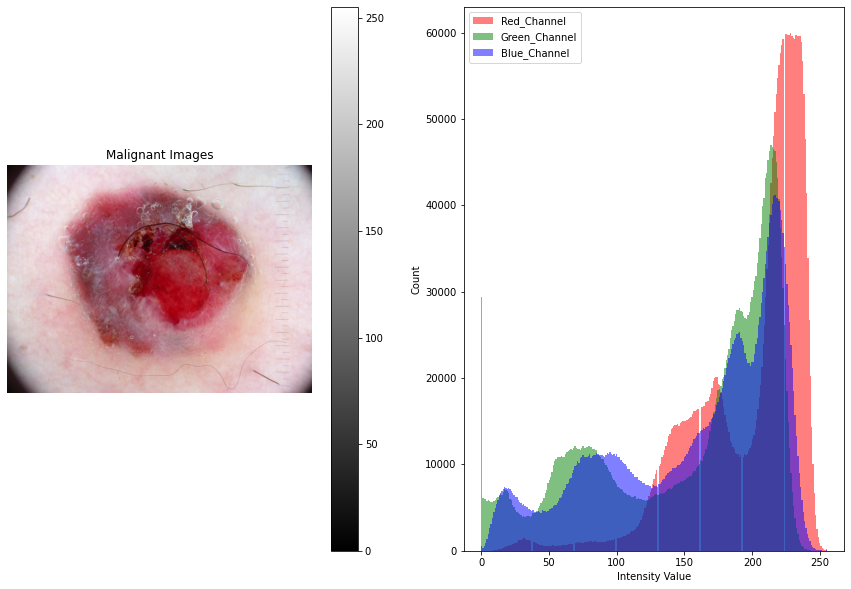

In [ ]:
img = cv2.imread('/content/drive/MyDrive/CSE499/Dataset/train/malignant/ISIC_0000146.jpeg')
f = plt.figure(figsize=(15,10))
f.add_subplot(1,2,1)

images = plt.imread('/content/drive/MyDrive/CSE499/Dataset/train/malignant/ISIC_0000146.jpeg')
plt.imshow(images, cmap='gray')
plt.axis('off')
plt.colorbar()
plt.title('Malignant Images')

f.add_subplot(1,2,2)
_= plt.hist(images[:, :, 0].ravel(), bins = 256, color = 'red', alpha = 0.5)
_ = plt.hist(images[:, :, 1].ravel(), bins = 256, color = 'Green', alpha = 0.5)
_ = plt.hist(images[:, :, 2].ravel(), bins = 256, color = 'Blue', alpha = 0.5)
_ = plt.xlabel('Intensity Value')
_ = plt.ylabel('Count')
_ = plt.legend(['Red_Channel', 'Green_Channel', 'Blue_Channel'])
plt.show()

**Create Label for each class 0 = Benign , 1 = malignant**

In [ ]:
benign_train_label = np.zeros(len(benign_train),dtype=float)
malign_train_label = np.ones(len(malign_train),dtype=float)
benign_test_label = np.zeros(len(benign_test),dtype=float)
malign_test_label = np.ones(len(malign_test),dtype=float) 

X_train = np.concatenate((benign_train, malign_train), axis = 0)
Y_train = np.concatenate((benign_train_label, malign_train_label), axis = 0)
X_test = np.concatenate((benign_test, malign_test), axis = 0)
Y_test = np.concatenate((benign_test_label, malign_test_label), axis = 0)

s = np.arange(X_train.shape[0])
np.random.shuffle(s)
X_train = X_train[s]
Y_train = Y_train[s]

s = np.arange(X_test.shape[0])
np.random.shuffle(s)
X_test = X_test[s]
Y_test = Y_test[s]

Y_train = to_categorical(Y_train, num_classes= 2)
Y_test = to_categorical(Y_test, num_classes= 2)

In [ ]:
print(f'X train shape:',X_train.shape)
print(f'X test shape:',X_test.shape)
print(f'Y train shape:',Y_train.shape)
print(f'Y test shape:',Y_test.shape)

X train shape: (6996, 224, 224, 3)
X test shape: (3000, 224, 224, 3)
Y train shape: (6996, 2)
Y test shape: (3000, 2)


**Split the Train and Valid**

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=10)

In [ ]:
print(f'x train shape:',x_train.shape)
print(f'x val shape:',x_val.shape)
print(f'y train shape:',y_train.shape)
print(f'y val shape:',y_val.shape)

x train shape: (5596, 224, 224, 3)
x val shape: (1400, 224, 224, 3)
y train shape: (5596, 2)
y val shape: (1400, 2)


**Let's display Some images**

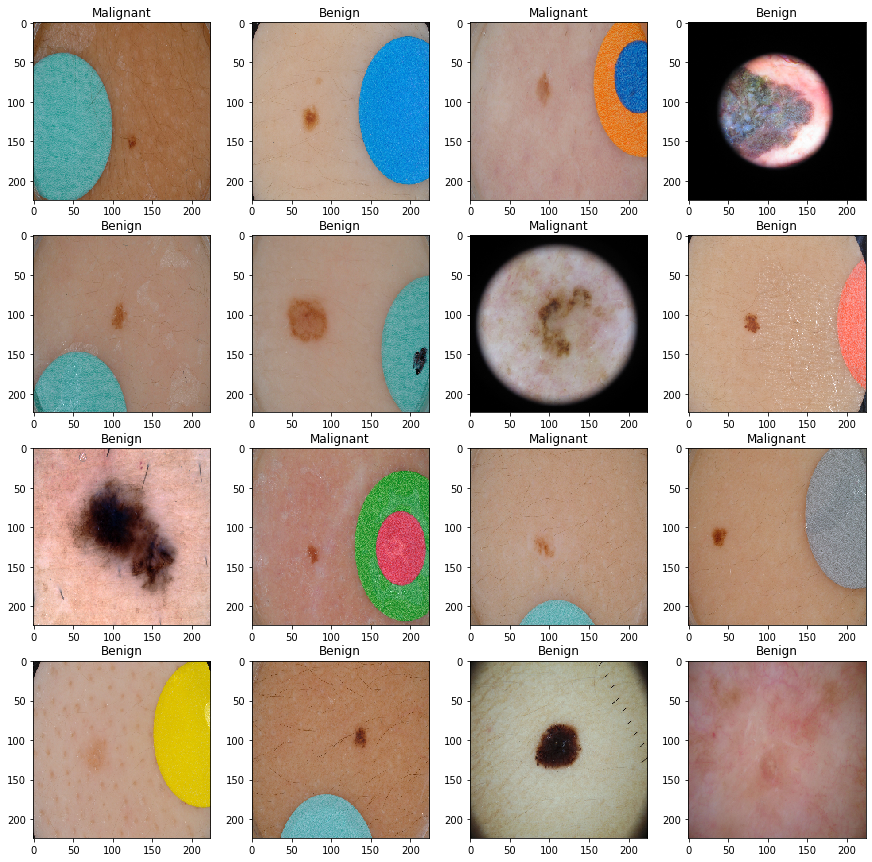

In [ ]:
w = 60
h = 40
fig = plt.figure(figsize=(15, 15))
columns = 4
rows = 4

for i in range(1, columns*rows +1): 
    ax = fig.add_subplot(rows, columns, i)
    if np.argmax(Y_train[i]) == 0:
        ax.title.set_text('Benign')
    else:
        ax.title.set_text('Malignant')
    plt.imshow(x_train[i], interpolation='nearest')
plt.show()

**ResNet50 as a Teacher model**

In [ ]:
# Teacher model with ResNet50
def build_model(backbone , lr = 1e-4):
  model = Sequential()
  model.add(backbone)
  model.add(layers.GlobalAveragePooling2D())
  model.add(layers.Dropout(0.5))
  model.add(layers.BatchNormalization())
  model.add(layers.Dense(2 , activation='softmax'))
  
  model.compile(
        loss='categorical_crossentropy',
        optimizer=Adam(learning_rate=lr),
        metrics=['accuracy']
    )
    
  return model


resnet = ResNet50(
    weights = 'imagenet',
    include_top = False,
    input_shape =(224 , 224 , 3)
)
#call the model 
model = build_model(resnet , lr = 1e-4)
model.build((None, 224, 224, 3))
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
module_wrapper_8 (ModuleWrap (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_8 ( (None, 2048)              0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 2048)              0         
_________________________________________________________________
batch_normalization_8 (Batch (None, 2048)              8192      
_________________________________________________________________
dense_8 (Dense)              (None, 2)                 4098      
Total params: 23,600,002
Trainable params: 23,542,786
Non-trainable params: 57,216
_________________________________________________________________


**Training the teacher model with Resnet50**

In [ ]:
# Training the teacher model with Resnet50
# Train the teacher model as usual
epochs = 10
batch_size = 64
teacher_his = model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_val, y_val))

In [ ]:
#https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/
# summarize history for accuracy
plt.plot(teacher_his.history['accuracy'],)
plt.plot(teacher_his.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower left')
plt.show()

In [ ]:
#https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/
# summarize history for accuracy
plt.plot(teacher_his.history['loss'])
plt.plot(teacher_his.history['val_loss'])
plt.title('model Loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
Y_val_pred = model.predict(x_val)
print(f'The Accuracy on the Validation Set:',accuracy_score(np.argmax(y_val, axis=1), np.argmax(Y_val_pred, axis=1)))

The Accuracy on the Validation Set: 0.9335714285714286


In [ ]:
#Now let's check my Y_test values
print(f'My Y_test values are:\n' ,Y_test)

My Y_test values are:
 [[1. 0.]
 [0. 1.]
 [0. 1.]
 ...
 [0. 1.]
 [1. 0.]
 [1. 0.]]


In [ ]:
#Now let's check my predcited values from X_test dataset	
import timeit

start = timeit.default_timer()
#Your statements here
y_pred = model.predict(X_test)
print(f'My predicted Y_test values are:\n' ,y_pred)

stop = timeit.default_timer()
print('\nTime: ',stop - start,'sec')

My predicted Y_test values are:
 [[1.0000000e+00 5.1184506e-09]
 [7.0008603e-08 9.9999988e-01]
 [3.4695746e-11 1.0000000e+00]
 ...
 [1.6346553e-08 1.0000000e+00]
 [1.0000000e+00 1.1865103e-08]
 [1.0000000e+00 3.8212616e-10]]

Time:  17.877404368000498 sec


In [ ]:
#Now let's check the accuracy between the original & predicted (Y_test , y_pred)
print(f'My accuracy on Teacher model with ResNet50 on the Test set is:',accuracy_score(np.argmax(Y_test, axis=1), np.argmax(y_pred, axis=1)))

My accuracy on Teacher model with ResNet50 on the Test set is: 0.987


In [ ]:
# Print the classification report
print(classification_report( np.argmax(Y_test, axis=1), np.argmax(y_pred, axis=1)))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1500
           1       1.00      0.97      0.99      1500

    accuracy                           0.99      3000
   macro avg       0.99      0.99      0.99      3000
weighted avg       0.99      0.99      0.99      3000



**AUC-ROC Curve**

In [ ]:
from sklearn.metrics import roc_curve

# roc curve for models
fpr1, tpr1, thresh1 = roc_curve(np.argmax(Y_test, axis=1), np.argmax(y_pred, axis=1),pos_label=1)

# roc curve for
random_probs = [0 for i in range(len(np.argmax(Y_test, axis=1)))]
p_fpr, p_tpr, _ = roc_curve(np.argmax(Y_test, axis=1), random_probs, pos_label=1)

# auc scores
from sklearn.metrics import roc_auc_score
auc_score1 = roc_auc_score(np.argmax(Y_test, axis=1), np.argmax(y_pred, axis=1))
print(auc_score1)

0.9870000000000001


In [ ]:
# matplotlib
import matplotlib.pyplot as plt
plt.style.use('seaborn')

# plot roc curves
plt.plot(fpr1, tpr1, linestyle='--',color='orange')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
# title
plt.title('ROC curve')
# x label
plt.xlabel('\nFalse Positive Rate')
# y label
plt.ylabel('\nTrue Positive rate')

plt.legend(loc='best')
plt.savefig('ROC',dpi=300)
plt.show();

**The Student Model**

In [ ]:
# Define the student model
# Student model that is stand-alone. We will evaluate its accuracy compared to a teacher trained student model
# Hyperparameters
input_shape = (224, 224, 3) # Input shape of each image
nb_classes = 2 


student = Sequential()
student.add(Conv2D(128, kernel_size=(3, 3),activation='relu', input_shape=input_shape))
student.add(MaxPooling2D(pool_size=(2, 2)))
student.add(Conv2D(64, (3, 3), activation='relu'))
student.add(MaxPooling2D(pool_size=(2, 2)))
student.add(Conv2D(32, (3, 3), activation='relu'))
student.add(Dropout(0.25)) # For reguralization

student.add(layers.Flatten())

student.add(layers.Dense(nb_classes))
student.add(layers.Activation('softmax')) # Note that we add a normal softmax layer to begin with


student.compile(loss='categorical_crossentropy',
              optimizer='adadelta',
              metrics=['accuracy'])

print(student.summary())

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 128)     3584      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 128)     0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 109, 109, 64)      73792     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 52, 52, 32)        18464     
_________________________________________________________________
dropout_9 (Dropout)          (None, 52, 52, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 86528)            

**Check Temperature**

In [ ]:
# Define a new model that outputs only teacher logits
# Raise the temperature of teacher model and gather the soft targets
#Collect the logits from the previous layer output and store it in a different model
teacher_WO_Softmax = Model(model.input, model.get_layer('dense_8').output)

In [ ]:
# Define a manual softmax function
def softmax(x):
    return np.exp(x)/(np.exp(x).sum())

[[0.2770396 0.7229604]]




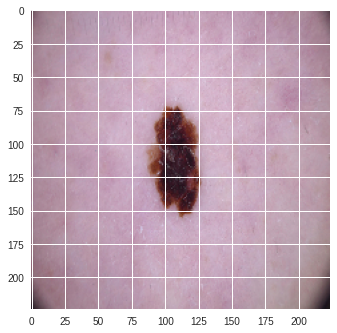

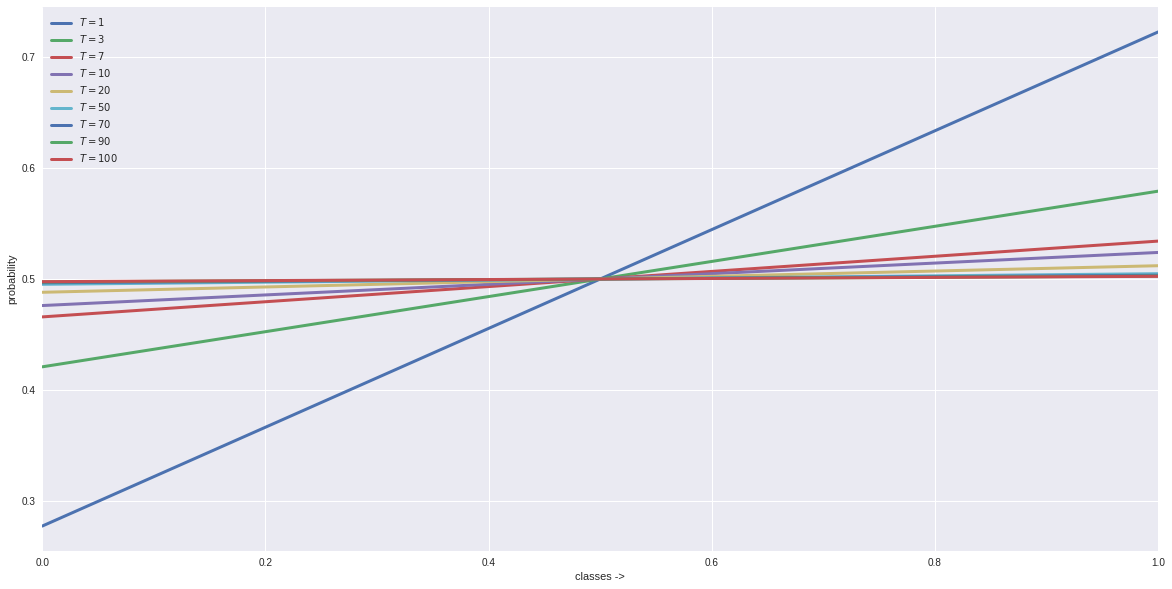

In [ ]:
# For example, just grab the first image and lets see how softening of probabilities work
intermediate_output = teacher_WO_Softmax.predict(x_train[122].reshape(1,224,224,3))
print(softmax(intermediate_output))
print('\n')

pixels = x_train[122]
pixels = pixels.reshape((224, 224, 3))
plt.imshow(pixels)
plt.show()
print('\n')

# logits for the first number in test dataset
x = intermediate_output[0]
plt.figure(figsize = (20, 10));

temperature = [1,3,7,10,20,50,70,90,100]

for temp in temperature:
    plt.plot((softmax(x/temp)), label='$T='+str(temp)+'$', linewidth=3);
    plt.legend();
plt.xlabel('classes ->');
plt.ylabel('probability');
plt.xlim([0, 1]);
plt.show()

# Temperature = 3


In [ ]:
# Prepare the soft targets and the target data for student to be trained upon

temp = 3
# This model directly gives the logits ( see the teacher_WO_softmax model above)
teacher_train_logits = teacher_WO_Softmax.predict(x_train)
teacher_test_logits = teacher_WO_Softmax.predict(x_val) 

# Perform a manual softmax at raised temperature
train_logits_T = teacher_train_logits/ temp # temp = 3
test_logits_T = teacher_test_logits / temp 

Y_train_soft = softmax(train_logits_T)
Y_test_soft = softmax(test_logits_T)

# Concatenate 
Y_train_new = np.concatenate([y_train, Y_train_soft], axis=1)
Y_test_new =  np.concatenate([y_val, Y_test_soft], axis =1)

#Print the Shape 
print(train_logits_T.shape)
print(test_logits_T.shape)
print(Y_train_new.shape)
print(Y_test_new.shape)

(5596, 2)
(1400, 2)
(5596, 4)
(1400, 4)


In [ ]:
# Prepare the student model that outputs probabilities with and without temperature
# Remove the softmax layer from the student network
student.layers.pop()

# Now collect the logits from the last layer
# This is going to be a tensor. And hence it needs to pass through a Activation layer
logits = student.layers[-1].output 
probs = layers.Activation('softmax')(logits)


# softed probabilities at raised temperature
logits_T = Lambda(lambda x: x / temp)(logits)
probs_T = layers.Activation('softmax')(logits_T)

output = concatenate([probs, probs_T])

# This is our new student model
student = Model(student.input, output)

student.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
conv2d_input (InputLayer)       [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 222, 222, 128 3584        conv2d_input[0][0]               
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 111, 111, 128 0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 109, 109, 64) 73792       max_pooling2d[0][0]              
____________________________________________________________________________________________

In [ ]:
tf.keras.utils.plot_model(student, "multi_input_and_output_model.png", show_shapes=True)

In [ ]:
# Declare knowledge distillation loss function
# This will be a teacher trained student model. 
# This uses a knowledge distillation loss function

# Declare knowledge distillation loss
def knowledge_distillation_loss(y_true, y_pred, alpha):

    # Extract the one-hot encoded values and the softs separately so that we can create two objective functions
    y_true, y_true_softs = y_true[: , :nb_classes], y_true[: , nb_classes:]
    
    y_pred, y_pred_softs = y_pred[: , :nb_classes], y_pred[: , nb_classes:]
    
    loss = alpha*logloss(y_true,y_pred) + (1-alpha)*logloss(y_true_softs, y_pred_softs)
    
    return loss

# For testing use regular output probabilities - without temperature
def acc(y_true, y_pred):
    y_true = y_true[:, :nb_classes]
    y_pred = y_pred[:, :nb_classes]
    return categorical_accuracy(y_true, y_pred)

student.compile(
    #optimizer=optimizers.SGD(lr=1e-1, momentum=0.9, nesterov=True),
    optimizer='adadelta',
    loss=lambda y_true, y_pred: knowledge_distillation_loss(y_true, y_pred, 0.1),
    #loss='categorical_crossentropy',
    metrics=[acc] )

In [ ]:
# Train the student model
epochs = 20
batch_size = 64
student_his = student.fit(x_train, Y_train_new,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_val, Y_test_new))

Epoch 1/20
88/88 [==============================] - 46s 428ms/step - loss: 0.0806 - acc: 0.5077 - val_loss: 0.0805 - val_acc: 0.5129
Epoch 2/20
88/88 [==============================] - 33s 376ms/step - loss: 0.0818 - acc: 0.4929 - val_loss: 0.0804 - val_acc: 0.5136
Epoch 3/20
88/88 [==============================] - 33s 378ms/step - loss: 0.0802 - acc: 0.5097 - val_loss: 0.0803 - val_acc: 0.5150
Epoch 4/20
88/88 [==============================] - 33s 377ms/step - loss: 0.0782 - acc: 0.5284 - val_loss: 0.0800 - val_acc: 0.5179
Epoch 5/20
88/88 [==============================] - 33s 378ms/step - loss: 0.0804 - acc: 0.5089 - val_loss: 0.0794 - val_acc: 0.5229
Epoch 6/20
88/88 [==============================] - 33s 377ms/step - loss: 0.0787 - acc: 0.5246 - val_loss: 0.0768 - val_acc: 0.5471
Epoch 7/20
88/88 [==============================] - 33s 378ms/step - loss: 0.0780 - acc: 0.5255 - val_loss: 0.0649 - val_acc: 0.6593
Epoch 8/20
88/88 [==============================] - 33s 377ms/step - 

In [ ]:
#https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/
# summarize history for accuracy
plt.plot(student_his.history['acc'])
plt.plot(student_his.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
#https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/
# summarize history for accuracy
plt.plot(student_his.history['loss'])
plt.plot(student_his.history['val_loss'])
plt.title('model loss')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower left')
plt.show()

In [ ]:
Y_val_pred = student.predict(x_val)
print(f'The Accuracy on the Validation Set:',accuracy_score(np.argmax(y_val, axis=1), np.argmax(Y_val_pred, axis=1)))

The Accuracy on the Validation Set: 0.7857142857142857


In [ ]:
#Now let's check my Y_test values
print(f'My Y_test values are:\n' ,Y_test)

My Y_test values are:
 [[1. 0.]
 [0. 1.]
 [0. 1.]
 ...
 [0. 1.]
 [1. 0.]
 [1. 0.]]


In [ ]:
#Now let's check my predcited values from X_test dataset	
import timeit

start = timeit.default_timer()
#Your statements here
y_pred = student.predict(X_test)
print(f'My predicted Y_test values are:\n' ,y_pred)

stop = timeit.default_timer()
print('\nTime: ',stop - start,'sec')

My predicted Y_test values are:
 [[0.73105854 0.26894143 0.5825702  0.4174298 ]
 [0.7310183  0.26898175 0.58255357 0.4174464 ]
 [0.69725263 0.30274737 0.5690762  0.43092382]
 ...
 [0.37646285 0.6235372  0.45804974 0.5419502 ]
 [0.73105854 0.26894143 0.5825702  0.4174298 ]
 [0.73105854 0.26894143 0.5825702  0.4174298 ]]

Time:  6.571369817000232 sec


In [ ]:
#Now let's check the accuracy between the original & predicted (Y_test , y_pred)
print(f'My accuracy on Teacher model with ResNet50 on the Test set is:',accuracy_score(np.argmax(Y_test, axis=1), np.argmax(y_pred, axis=1)))

My accuracy on Teacher model with ResNet50 on the Test set is: 0.8286666666666667


In [ ]:
# Print the classification report
print(classification_report( np.argmax(Y_test, axis=1), np.argmax(y_pred, axis=1)))

              precision    recall  f1-score   support

           0       0.76      0.96      0.85      1500
           1       0.94      0.70      0.80      1500

    accuracy                           0.83      3000
   macro avg       0.85      0.83      0.83      3000
weighted avg       0.85      0.83      0.83      3000



In [ ]:
from sklearn.metrics import roc_curve

# roc curve for models
fpr1, tpr1, thresh1 = roc_curve(np.argmax(Y_test, axis=1), np.argmax(y_pred, axis=1),pos_label=1)

# roc curve for
random_probs = [0 for i in range(len(np.argmax(Y_test, axis=1)))]
p_fpr, p_tpr, _ = roc_curve(np.argmax(Y_test, axis=1), random_probs, pos_label=1)

# auc scores
from sklearn.metrics import roc_auc_score
auc_score1 = roc_auc_score(np.argmax(Y_test, axis=1), np.argmax(y_pred, axis=1))
print(auc_score1)


# matplotlib
import matplotlib.pyplot as plt
plt.style.use('seaborn')

# plot roc curves
plt.plot(fpr1, tpr1, linestyle='--',color='orange')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
# title
plt.title('ROC curve')
# x label
plt.xlabel('\nFalse Positive Rate')
# y label
plt.ylabel('\nTrue Positive rate')

plt.legend(loc='best')
plt.savefig('ROC',dpi=300)
plt.show();

END